In [272]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import plotting
import importlib
importlib.reload(plotting)

<module 'plotting' from '/home/frankwoods/Desktop/lassie/plotting.py'>

# Load in all depth vs resistance curves into a dataframe list

In [273]:
def load_data(data_src):
    depth_resist_curve_df_list = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        depth_resist_curve_df_list.append(df)
        filename_list.append(filename)
    return depth_resist_curve_df_list, filename_list

data_src = "data/cleaned_data"
depth_resist_curve_df_list, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, depth_resist_curve_df_list))

In [274]:
data_features_df = pd.read_csv("data/features.csv")
non_clustering_features_list = ['filenames', 'feifeis_ylabels', 'liams_ylabels', 'marions_ylabels', 'distances']
clustering_features_df = data_features_df.drop(non_clustering_features_list, axis=1)

# Extract ground truth means

In [275]:
"""
make list of cluster names
create a dict with key is cluster name and value is a df with just those vals
then create an average centoid
plot it 

what next do? and
"""

'\nmake list of cluster names\ncreate a dict with key is cluster name and value is a df with just those vals\nthen create an average centoid\nplot it \n\nwhat next do? and\n'

# K-Means Clustering Implementation w/ k-means++ initialization for centroids

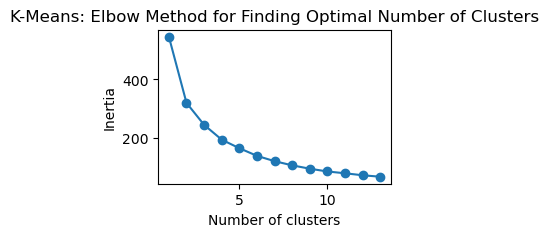

In [276]:
inertias = []
for k in range(1,14):
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=100).fit(clustering_features_df)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(3,2))
plt.plot(range(1,14), inertias, marker='o')
plt.title("K-Means: Elbow Method for Finding Optimal Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid=True
plt.show()

# K-Means Clustering
- assumes
    - spherical clusters (isotropic)
    - similar size clusters (equal variance)
    - features are on same scale
    - clusters are linearly separable
    - number of clusters (k) is known

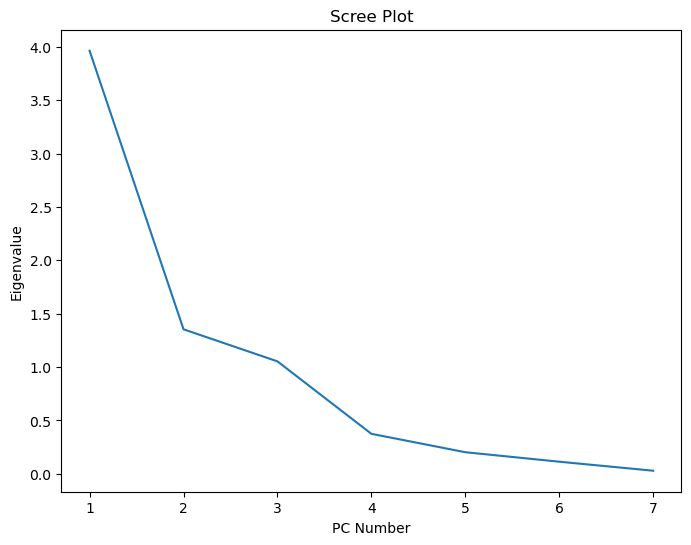

    Eigenvalue  Proportion  Cumulative
PC                                    
1     3.963054    0.558892    0.558892
2     1.353832    0.190925    0.749817
3     1.053480    0.148568    0.898385
4     0.374894    0.052870    0.951255
5     0.202537    0.028563    0.979818
6     0.113808    0.016050    0.995867
7     0.029304    0.004133    1.000000


                               PC1       PC2       PC3       PC4       PC5  \
overall_slope            -0.465162  0.288576  0.046561  0.234288  0.025073   
max_depth                 0.466035 -0.235240  0.021241 -0.191534 -0.255399   
max_resistance           -0.438838  0.337824  0.080647  0.166702 -0.378223   
num_peaks                 0.421306  0.022784  0.116898  0.874123 -0.185582   
largest_force_drop        0.305590  0.614393 -0.152378 -0.295196 -0.552843   
curve_shape               0.017716  0.003734  0.973022 -0.171101 -0.086719   
largest_force_drop_level  0.320406  0.607659  0.084980 -0.011344  0.665953   

                      

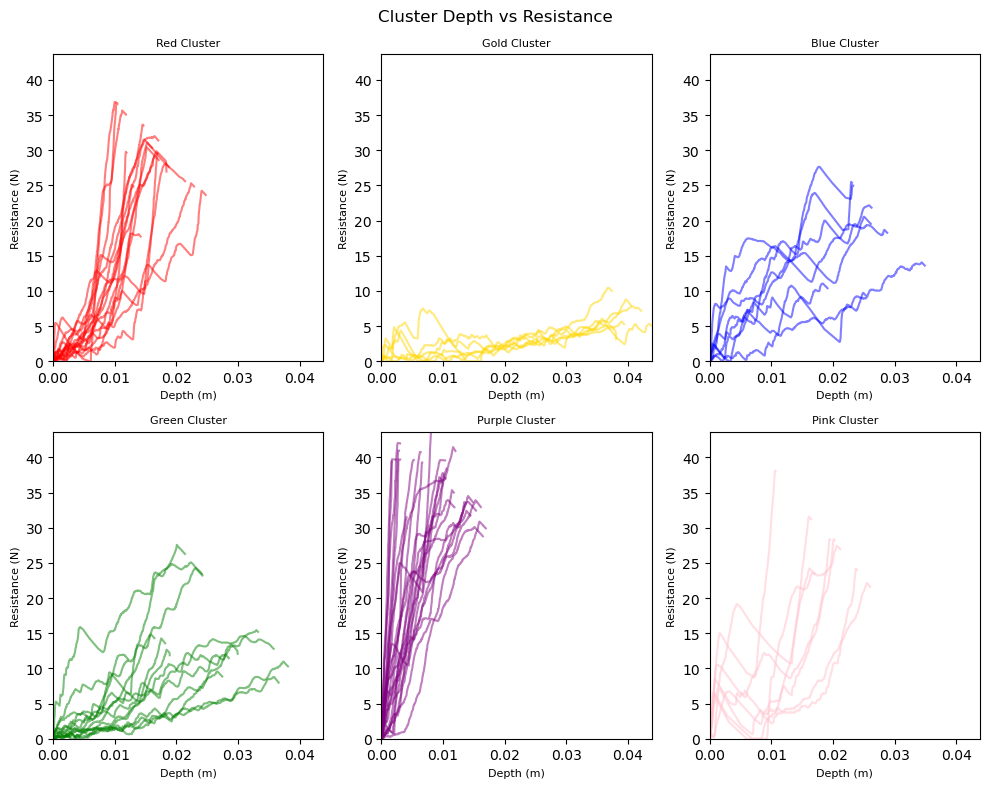

In [277]:
kmeans_elbow = 6
kmeans = KMeans(n_clusters=kmeans_elbow, init="k-means++", n_init=100).fit(clustering_features_df)
# print(f"kmeans cluster centers: {kmeans.cluster_centers_}")
plotting.pca_analysis(clustering_features_df) # printing scree plot
# plotting.plot_clusters_together(kmeans.labels_, "kmeans")
plotting.plot_clusters_seperately(kmeans.labels_, clustering_features_df.index.tolist(), depth_resist_curve_df_list, data_features_df, "kmeans")
plotting.plot_pca(clustering_features_df, y_labels=kmeans.labels_, num_pc=3, graph_title="kmeans")

# Hierarchical Clustering

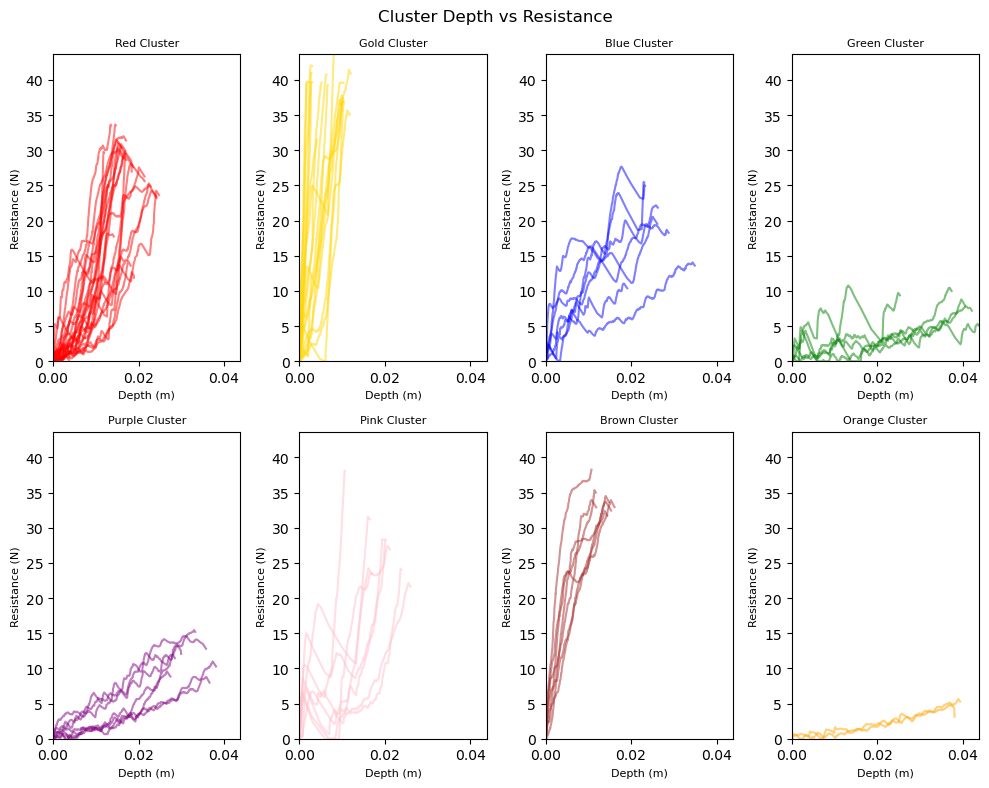

In [278]:

# if distance_threshold != None then n_clusters = None
hierarchical = AgglomerativeClustering(distance_threshold=None, n_clusters=8)
hierarchical.fit(clustering_features_df)
linkage = "Ward"
plotting.plot_clusters_seperately(hierarchical.labels_, clustering_features_df.index.tolist(), depth_resist_curve_df_list, data_features_df, 'hierarchical')
plotting.plot_pca(clustering_features_df, y_labels=hierarchical.labels_, num_pc=3, graph_title="hierachical")

# DBSCAN

In [279]:

# eps=0.7, min_samples=3 works very well
# dbscan = DBSCAN(eps=1.8, min_samples=10).fit(clustering_features_df)
# cleaned_db_labels = [label if label != -1 else max(dbscan.labels_)+1 for label in dbscan.labels_]
# # get_curve_idx_from_cluster_color("yellow", cleaned_db_labels)
# plotting.plot_pca(clustering_features_df, cleaned_db_labels, 'dbscan')
# plotting.plot_clusters_seperately(cleaned_db_labels, clustering_features_df.index.to_list(), depth_resist_curve_df_list)